In [3]:
import os
import sys
sys.path.append('..')
import numpy as np
import os
import matplotlib.pyplot as plt

import analysis


from importlib import reload

In [4]:
reload(analysis)

data_dir = "/SNS/NOM/IPTS-34537/shared/sliced/reduced/GSAS"

temps, ramp = analysis.load_data(data_dir)


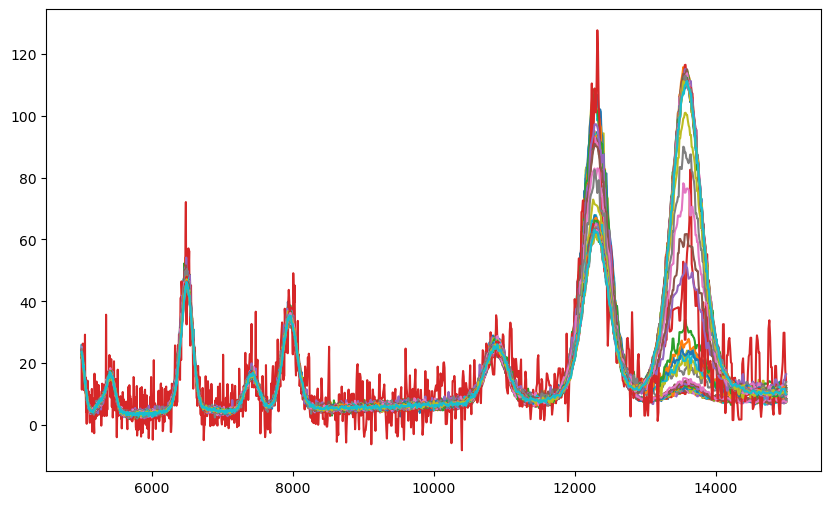

In [5]:
plt.figure(figsize=(10, 6))

for i, r in enumerate(ramp[25:75]):
    idx = [(v >= 5000) & (v <= 17500) for v in r[0]]
    plt.plot(r[0][idx], r[1][idx], label=f'Run {i}')

#plt.legend()

103.0


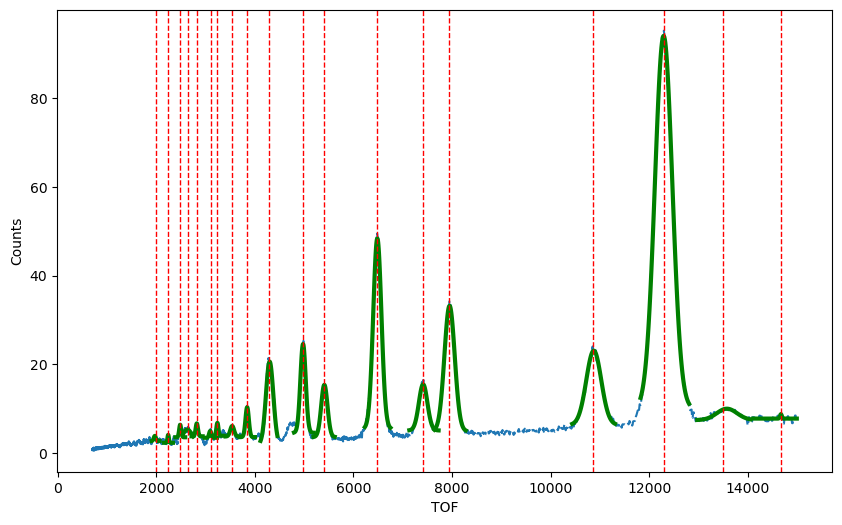

In [117]:
reload(analysis)

#index = 30
index = 1


tof = ramp[index][0]
counts = ramp[index][1]
print(temps[index])

peaks = analysis.peak_finder(tof, counts, peak_prominence=2)

In [105]:
print(peaks)

[1302 1456 1582 1659 1743 1860 1913 2026 2128 2263 2454 2553 2782 2951
 3037 3427 3583 3699 3804]


Number of peaks 3
[0.1931207701964643, 0.20146207484865655, 0.13840335389918115, 0.20021464573252112, 0.24604040368564323, 0.2280740236521343, 0.14249073477070326, 0.2128790604321874, 0.1946147523724336, 0.2100009932187343, 0.16655460301115033, 0.15922304758484007, 0.2139332369226165, 0.20484733359770144, 0.16315515260426108, 0.15256209042234814, 0.18441603045481628, 0.22609497233173922, 0.2189066290122589, 0.20156420434961136, 0.2244372721851786, 0.15827014775813783, 0.24056229762053108, 0.18556566703195418, 0.22265001338015863, 0.19421554566179505, 0.24390566172450412, 0.14508566339561366, 0.18404709167840796, 0.19383090458417893, 0.21494739694136708, 1.290414756362266, 2.319491074416647, 1.2984119337246252, 1.355257239180512, 0.8475361842528433, 2.127081045304658, 1.589316369941268, 1.3951977379163583, 2.332296285778364, 2.9846976795708957, 1.3488978599215926, 1.9758265272852158, 2.094841886212554, 2.045373633687274, 2.3712643641452735, 1.7197400050464164, 2.1037750844688206, 2.2785

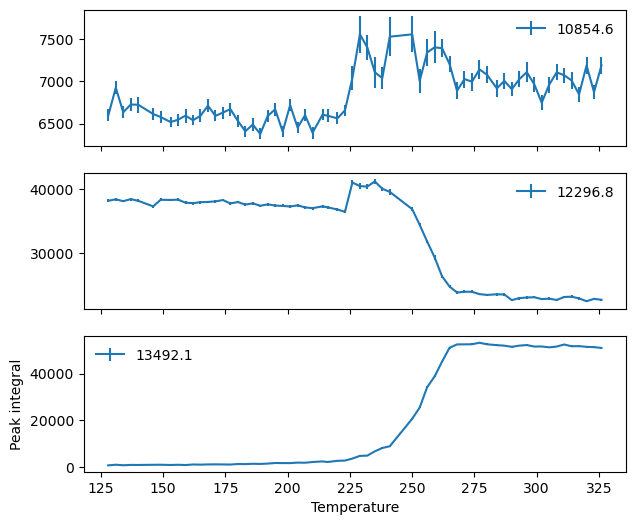

(3, 63)


In [180]:
reload(analysis)

_peaks = [3427, 3583, 3699]
start_idx = 48
start_idx = 5
last_idx = 75
t, a, d_a = analysis.series_analyzer(ramp[start_idx:last_idx], _peaks, temps[start_idx:last_idx])
print(a.shape)
#for i in range(len(t)):
#    print(i, t[i], a[0][i], d_a[0][i])

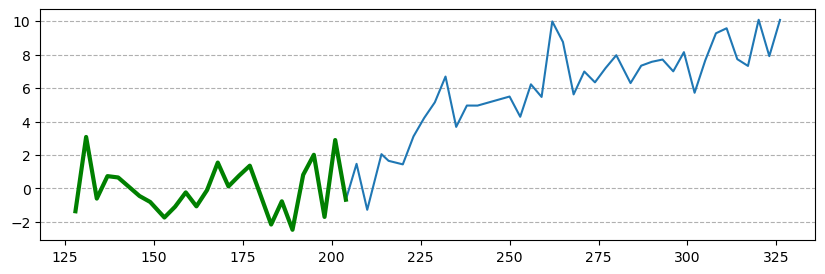

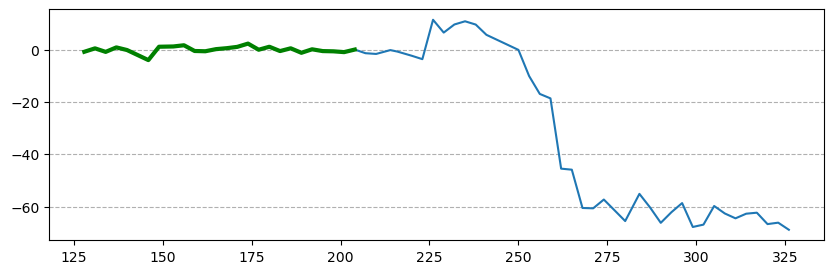

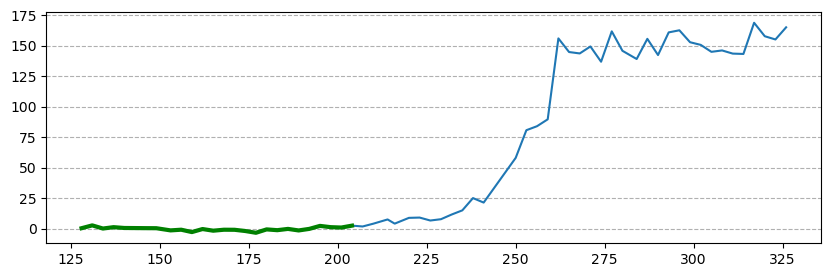

In [200]:
from scipy.stats import linregress
total = 0
previous = 0

averaging = 25

def process_ramp(j):
    diff_list = []
    err_list = []

    for i in range(len(t)):
        slope, intercept, r, p, se = linregress(t[:averaging], a[j][:averaging])

        #prev_avg = np.mean(a[j][:averaging])
        prev_avg = intercept + slope * t[i]

        diff = a[j][i] - prev_avg
        
        err_diff = d_a[j][i] # Rough approx

        diff_list.append(diff)
        err_list.append(err_diff)

    diff_list = np.asarray(diff_list)
    err_list = np.asarray(err_list)

    plt.figure(figsize=(10, 3))

    if True:
        plt.plot(t, diff_list/err_list, linestyle="-")
        plt.plot(t[:averaging], (diff_list/err_list)[:averaging], color='green', linestyle="-", linewidth=3)
    else:
        plt.errorbar(t, diff_list, yerr=err_list)
    plt.grid(True, axis='y', which='major', linestyle="--")


#plt.figure(figsize=(10, 6))
process_ramp(0)
process_ramp(1)
process_ramp(2)

10854.633516282
8057.92789223786 +- 1022.5161487967803


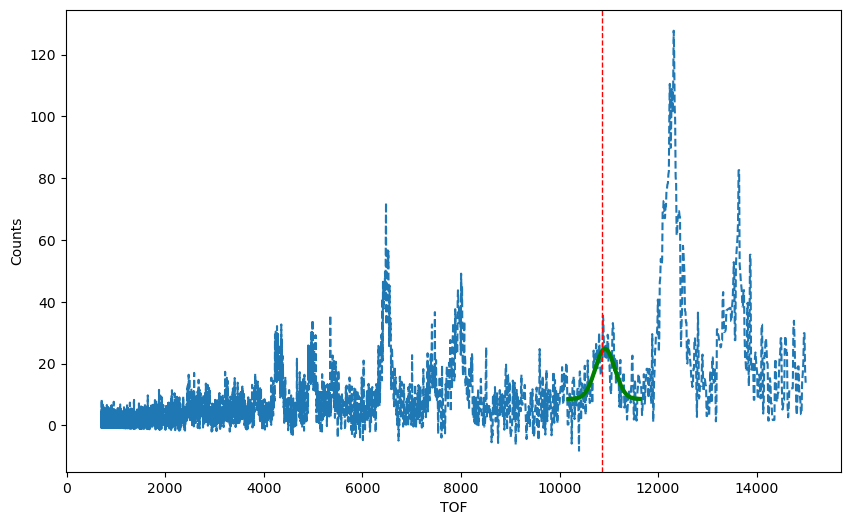

In [146]:
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.optimize import curve_fit
reload(analysis)

index = 48

tof = ramp[index][0]
counts = ramp[index][1]

peak = tof[_peaks[0]]
print(peak)


delta = tof / 15
mask = (tof > peak - delta) & (tof < peak + delta)

popt, pcov = curve_fit(
    analysis.gaussian,
    tof[mask],
    counts[mask],
    p0=[counts[mask].max(), peak, 10, counts[mask].min()],
)
perr = np.sqrt(np.diag(pcov))
a = np.fabs(popt[0] * popt[2] * np.sqrt(2 * np.pi))
err_a = np.sqrt(2 * np.pi) * np.sqrt(
    popt[0] ** 2 * perr[2] ** 2 + popt[2] ** 2 * perr[0] ** 2
)

print(f"{a} +- {err_a}")

plt.figure(figsize=(10, 6))
plt.plot(tof, counts, linestyle="--")
plt.plot(
    tof[mask],
    analysis.gaussian(tof[mask], *popt),
    color="green",
    linestyle="-",
    linewidth=3,
)
plt.axvline(x=peak, color="r", linestyle="--", linewidth=1)

plt.xlabel("TOF")
plt.ylabel("Counts")
plt.show()